## Statistical Analysis

Now that the data is cleaned and I've conducted some preliminary analysis, it's time to enrich my exploration with inferential statistics. My exploratory data analysis will include the following steps:
   1. Look for numerical variables in the dataset that are correlated.
   2. Run confidence intervals and significance tests on variables that are related to the project question.
   3. Re-evaluate the original project question based on statistical evidence.

Once again, I will focus on the listings dataset in this notebook, as the listing data hosts all numerical features that the dataset currently has. The reviews data, which contains the review text for different listings, will be interpreted using NLP later on in the project process, as will other text data in the listings file.

In [1]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import relevant packages
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# set seaborn theme
sns.set(style='ticks')

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# load listings dataset
df = pd.read_csv('/Users/limesncoconuts2/datasets/capstone_one/los_angeles/los-angeles_listings.csv')
df.head()

access  accommodates  availability_30  availability_365  availability_60  \
0    NaN           2.0             30.0             365.0             60.0   
1    NaN           1.0             30.0             365.0             60.0   
2    NaN           1.0             15.0             344.0             39.0   
3    NaN           2.0             18.0             261.0             32.0   
4    NaN           1.0             30.0             365.0             60.0   

   availability_90  bathrooms  bed_type  bedrooms  beds  \
0             90.0        1.0  Real Bed       1.0   1.0   
1             90.0        1.0  Real Bed       1.0   1.0   
2             69.0        1.0     Couch       1.0   1.0   
3             62.0        1.0  Real Bed       1.0   1.0   
4             90.0        1.0     Futon       1.0   1.0   

             ...             phone_verification photographer_verification  \
0            ...                           True                     False   
1            ...                           True                     False   
2            ...                           True                     False   
3            ...                           True                     False   
4            ...                           True                     False   

  reviews_verification selfie_verification sent_id_verification  \
0                 True               False                False   
1                False               False                False   
2                 True               False                False   
3                False               False                False   
4                 True               False                False   

   sesame_verification sesame_offline_verification weibo_verification  \
0                False                       False              False   
1                False                       False              False   
2                False                       False              False   
3                False                       False              False   
4                False                       False              False   

  work_email_verification zhima_selfie_verification  
0                   False                     False  
1                   False                     False  
2                   False                     False  
3                   False                     False  
4                   False                     False  

[5 rows x 316 columns]

This statistical analysis will focus on numerical and categorical data. The text data will be interpreted as features later on in the project process.

In [4]:
# fix categories that didn't transfer from the data cleaning notebook?
to_category = ['property_type','room_type','bed_type','cancellation_policy','market','neighbourhood','city','state','calendar_updated','host_neighbourhood']
for col_name in to_category:
        try:
            df[col_name] = df[col_name].astype('category')
        except KeyError:
            pass

In [5]:
# turn boolean columns into 0 or 1 integers
for col in df:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype('int64')

In [6]:
# cut down dataframe to include only numerical and categorical data
df = df.select_dtypes(include=['number', 'datetime', 'category'])

In [7]:
# one hot encode categorical data
df = pd.get_dummies(df, dummy_na=True)

In [8]:
df.interpolate(method='linear', axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599177 entries, 0 to 599176
Columns: 1696 entries, accommodates to state_nan
dtypes: float64(1696)
memory usage: 7.6 GB


### Random Forests Feature Importances

In [10]:
# random forests for feature selection
X = df.drop(['price_USD','neighbourhood_group_cleansed'], axis=1)
y = df.price_USD
SEED = 1

# select a random subset of X and y to use for the random forest (save on time)
X = X.sample(frac=0.33, random_state=SEED)
y = y.sample(frac=0.33, random_state=SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=SEED)

rf = RandomForestRegressor(n_estimators = 100,
                          min_samples_leaf = 0.15,
                          random_state = SEED)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse_test = MSE(y_test, y_pred)**(1/2)

print(rmse_test)

106.8054894753863


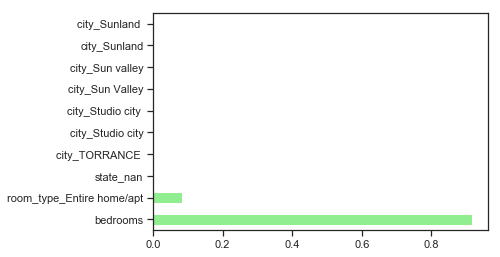

In [11]:
importances_rf = pd.Series(rf.feature_importances_,
                          index = X.columns)
sorted_importances_rf = importances_rf.sort_values(ascending=False)

sorted_importances_rf[0:10].plot(kind='barh',
                          color='lightgreen')
plt.show()

The most important features to our question seem to be bedrooms and if the room type is an entire home/apartment. It's important to note, however, that this is a very simplistic first-pass at the data, and that the feature importance algorithm for random forests shows some [bias towards continuous features or high-cardinality categorical variables](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e). Therefore, we should take this result with a grain of salt.

Next, I'll plot these features, as well as some other features I've previously identified as important, on a heatmap with price.

### Correlation-Finding

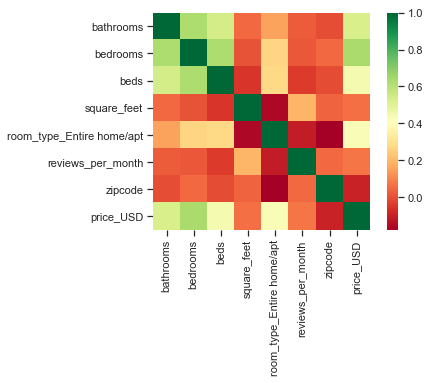

In [12]:
# heatmap for most influential features
cols = ['bathrooms', 'bedrooms', 'beds', 'square_feet', 'room_type_Entire home/apt', 'reviews_per_month', 'zipcode', 'price_USD']
sns.heatmap(df[cols].corr(), square=True, cmap='RdYlGn')

From looking at the 'price_USD' row of the heatmap, we see that 'bathrooms', 'bedrooms', 'beds', and 'room_type_Entire home/apt' all have some sort of correlation with price. Additionally, seeing that 'bedrooms' and 'beds' are correlated might indicate that we should remove 'beds' from the dataset.

Another way to check for correlation is by running hypothesis tests of correlation between a particular feature and price. By permuting one of the features and computing the Pearson correlation coefficient, we can see if the correlation we see between features is most likely by chance, or statistically significantly correlated.

### Statistical Testing

I will perform hypothesis tests for correlation for the three features that showed correlation with price: bathrooms, bedrooms, and room type (Entire home/apartment). 

The null hypothesis for these tests is that the two features are NOT correlated, with the alternative hypothesis being the opposite.

#### Bathrooms and Price

In [13]:
# conduct hypothesis test of correlation
# test statistic is the Pearson correlation coefficient (r)
alpha = 0.05
bathrooms = df['bathrooms'].astype(float)
price = df['price_USD'].astype(float)
obs_r = np.corrcoef(bathrooms, price)[0,1]
print('Observed Pearson correlation coefficient:', round(obs_r,3))

# use permutation to generate replicates of the data assuming no correlation is present
replicates = np.empty(10000)

for i in range(len(replicates)):
    # permute discharge data
    permuted = np.random.permutation(bathrooms)
    
    # compute r and add to replicates array
    replicates[i] = np.corrcoef(permuted, price)[0,1]
    
p_value = np.sum(replicates >= obs_r) / len(replicates)

print('p-value:', float(p_value))
if p_value < alpha:
    print('Reject null hypothesis')
else:
    print('Fail to reject null hypothesis')

Observed Pearson correlation coefficient: 0.53
p-value: 0.0
Reject null hypothesis


#### Bedrooms and Price

In [14]:
# conduct hypothesis test of correlation
# test statistic is the Pearson correlation coefficient (r)
alpha = 0.05
bedrooms = df['bedrooms'].astype(float)
price = df['price_USD'].astype(float)
obs_r = np.corrcoef(bedrooms, price)[0,1]
print('Observed Pearson correlation coefficient:', round(obs_r,3))

# use permutation to generate replicates of the data assuming no correlation is present
replicates = np.empty(10000)

for i in range(len(replicates)):
    # permute discharge data
    permuted = np.random.permutation(bedrooms)
    
    # compute r and add to replicates array
    replicates[i] = np.corrcoef(permuted, price)[0,1]
    
p_value = np.sum(replicates >= obs_r) / len(replicates)

print('p-value:', float(p_value))
if p_value < alpha:
    print('Reject null hypothesis')
else:
    print('Fail to reject null hypothesis')

Observed Pearson correlation coefficient: 0.632
p-value: 0.0
Reject null hypothesis


#### Room Type and Price

In [15]:
# conduct hypothesis test of correlation
# test statistic is the Pearson correlation coefficient (r)
alpha = 0.05
home = df['room_type_Entire home/apt'].astype(float)
price = df['price_USD'].astype(float)
obs_r = np.corrcoef(home, price)[0,1]
print('Observed Pearson correlation coefficient:', round(obs_r,3))

# use permutation to generate replicates of the data assuming no correlation is present
replicates = np.empty(10000)

for i in range(len(replicates)):
    # permute discharge data
    permuted = np.random.permutation(home)
    
    # compute r and add to replicates array
    replicates[i] = np.corrcoef(permuted, price)[0,1]
    
p_value = np.sum(replicates >= obs_r) / len(replicates)

print('p-value:', float(p_value))
if p_value < alpha:
    print('Reject null hypothesis')
else:
    print('Fail to reject null hypothesis')

Observed Pearson correlation coefficient: 0.433
p-value: 0.0
Reject null hypothesis


All three tests reject the null hypothesis, meaning that a correlation does exist between price and the three features of bedrooms, bathrooms, and room type.

### Re-evaluation of project question

The biggest finding of my statistical analysis is that it appears that the 'bedrooms' and 'room_type_entire Home/apt' features will most likely be important to the our machine learning model. Additionally, we had statistically significant confirmation that many of the features we thought were correlated indeed are. 

Moving forward, the machine learning analysis will likely offer more complex insights than this statistical analysis, especially as I incorporate information from the reviews data. It may be the case that some features that are not significant in this analysis play a larger role down the line.

This analysis does not alter the initial project question of trying to decipher a listing's price from its other features.